In [1]:
import os
import numpy as np
import galsim
import sys
import descwl
import argparse

import copy
%matplotlib inline
import matplotlib.pyplot as plt

#importing scarlet to make RGB images
import scarlet.display

sys.path.insert(0,os.path.dirname(os.getcwd()))
import btk
from btk import config

In [2]:
#Input catalog name
catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'OneDegSq.fits')

In [3]:
def plot_blends(blend_images, blend_list, detected_centers=None, limits=None):
    """Plots blend images as RGB(g,r,i) image, sum in all bands, and RGB with centers of objects marked"""
    batch_size = len(blend_list)
    if detected_centers is None:
        detected_centers = [[]]*batch_size
    for i in range(batch_size):    
        num = len(blend_list[i])
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        norm = scarlet.display.Asinh(img=images, Q=20)
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(8,3))
        plt.subplot(131)
        plt.imshow(blend_img_rgb)
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.title("gri bands")
        plt.axis('off')
        plt.subplot(132)
        plt.imshow(np.sum(blend_images[i, :, :, :], axis=2))
        plt.title("Sum")
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')

        plt.subplot(133)
        plt.imshow(blend_img_rgb)
        plt.title("%i objects with centers"%num)
        for entry in blend_list[i]:
            plt.plot(entry['dx'], entry['dy'],'rx')
        cond = np.all([blend_list[i]['not_drawn_' + b] == 1 for b in ['g', 'r', 'i']], axis=0)
        for entry in blend_list[i][cond]:
            plt.plot(entry['dx'], entry['dy'],'gx')
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.axis('off')
        plt.show()

def plot_with_isolated(blend_images, isolated_images,
                       blend_list, limits=None, detected_centers=None):
    """Plots blend images and isolated images of all objects in the blend as RGB(g,r,i) images"""
    if detected_centers is None:
        detected_centers = [[]]*len(blend_list)
    for i in range(len(blend_list)):    
        images = np.transpose(blend_images[i, :, :, 1:4], axes=(2,0,1))
        norm = scarlet.display.Asinh(img=images, Q=20)
        blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
        plt.figure(figsize=(2,2))
        plt.imshow(blend_img_rgb)
        plt.title("%i objects"%len(blend_list[i]))
        if limits:
            plt.xlim(limits)
            plt.ylim(limits)
        plt.axis('off')
        for cent in detected_centers[i]:
            plt.plot(cent[0], cent[1],'go', fillstyle='none')
        plt.show()
        iso_blend = isolated_images[i]
        num = iso_blend.shape[0]
        plt.figure(figsize=(2*num, 2))
        for j in range(num): 
            images = np.transpose(iso_blend[j, :, :, 1:4], axes=(2,0,1))
            blend_img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
            plt.subplot(1, num, j +1 )
            plt.imshow(blend_img_rgb)
            if limits:
                plt.xlim(limits)
                plt.ylim(limits)
            plt.axis('off')
            if len(detected_centers[i]) > 0:
                plt.plot(detected_centers[i][j][0], detected_centers[i][j][1],'go', fillstyle='none')
        plt.show()

In [4]:
def new_center_shift(Args, number_of_objects):
    """Set shift in galaxy centers from a normal distribution with mean 0 and std 1 arcseconds"""
    mean, sigma = 0, 1 #arcseconds
    dx = np.random.normal(mean, sigma, number_of_objects)
    dy = np.random.normal(mean, sigma, number_of_objects)
    return dx, dy
    
def new_sampling_function(Args, catalog):
    """ Samples galaxies with i<24, r-i>1. Number of objects ber blend is selected from a poisson
    distribution of mean 3. The number of objects is restricted to max_number. The centers of the objects 
    are set in new function new_center_shift()
    Note:Sampling function must clip the number of objects to Args.max_number!
    """
    # Set number of objets per blend
    number_of_objects = np.random.poisson(3)
    number_of_objects = np.minimum(number_of_objects, Args.max_number)
    
    # Make galaxy sample
    q, = np.where((catalog['i_ab'] <= 24) & (np.abs(catalog['i_ab'] - catalog['r_ab']) >1))
    blend_catalog = catalog[np.random.choice(q, size=number_of_objects)]
    
    # galaxy centers are sent as random shift from 0,0
    blend_catalog['ra'], blend_catalog['dec'] = 0., 0.
    dx, dy = new_center_shift(Args, number_of_objects)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    return blend_catalog

In [5]:
# Load parameters
param = config.Simulation_params(catalog_name, max_number=6, batch_size=5)
np.random.seed(param.seed)

#Load input catalog
catalog = btk.get_input_catalog.load_catlog(param)

#Generate catlogs of blended objects 
blend_genrator = btk.create_blend_generator.generate(param, catalog, new_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_genrator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_genrator, observing_genrator)    

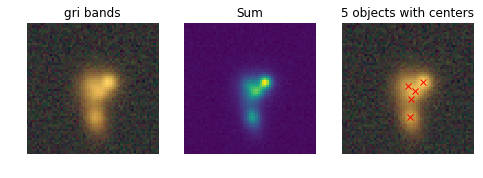

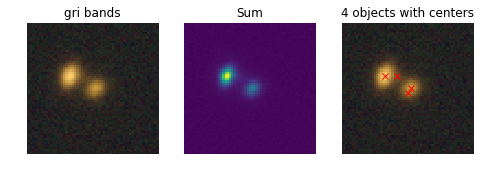

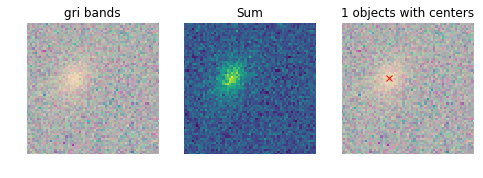

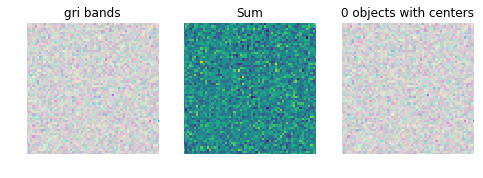

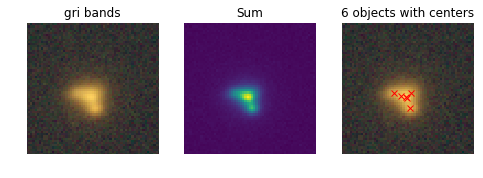

In [6]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends(blend_images, blend_list, limits=(30,90))

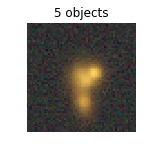

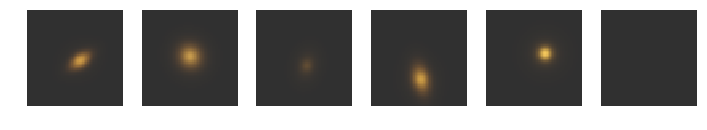

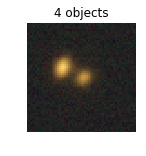

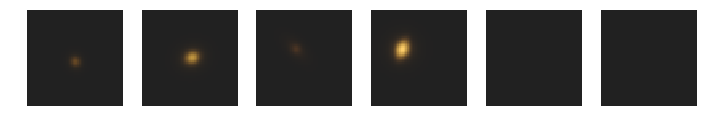

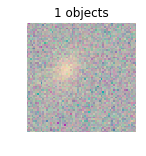

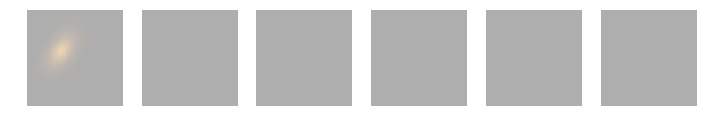

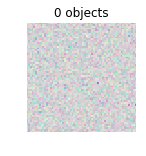

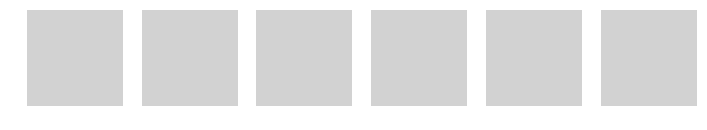

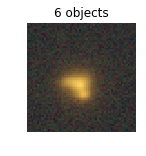

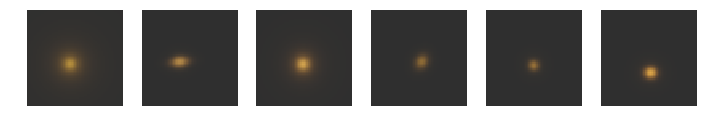

In [7]:
# Plot blended images and the individual objects
plot_with_isolated(blend_images, isolated_images,blend_list, limits=(30,90))

## Blends drawn as galaxies part of a group detremined by wld

In [8]:
import astropy.table

In [9]:
def get_random_shift(Args, number_of_objects, maxshift=None):
    """Returns a random shift from the center in x and y coordinates
    between 0 and max-shift (in arcseconds).
    """
    if not maxshift:
        maxshift = Args.stamp_size / 30.  # in arcseconds
    dx = np.random.uniform(-maxshift, maxshift,
                           size=number_of_objects)
    dy = np.random.uniform(-maxshift, maxshift,
                           size=number_of_objects)
    return dx, dy

def group_sampling_function(Args, catalog):
    """Blends are defined from *groups* of galaxies from the Cat-Sim like
    catalog previously analyzed with WLD. Function selects galaxies
    Note: the pre-run WLD images are not used here. We only use the pre-run
    catalog (in i band) to identify galaxies that belong to a group.

    Randomly picks entries from input catalog that are brighter than 25.3
    mag in the i band. The centers are randomly distributed within 1/5 of the
    stamp size.
    """
    if not hasattr(Args, 'wld_catalog'):
        raise Exception(
            "A pre-run WLD catalog should be input as Args.wld_catalog")
    else:
        wld_catalog = Args.wld_catalog 
    group_ids = np.unique(wld_catalog['grp_id'][wld_catalog['grp_size'] >= 5])
    group_id = np.random.choice(group_ids)
    ids = wld_catalog['db_id'][wld_catalog['grp_id'] == group_id]
    blend_catalog = astropy.table.vstack([catalog[catalog['galtileid'] == i] for i in ids])
    blend_catalog['ra'] -= np.mean(blend_catalog['ra'])
    blend_catalog['dec'] -= np.mean(blend_catalog['dec'])
    # convert ra dec from degrees to arcsec
    blend_catalog['ra'] *= 3600
    blend_catalog['dec'] *= 3600
    # Add small shift so that center does not perfectly align with stamp center
    dx, dy = get_random_shift(Args, 1, maxshift=3*Args.pixel_scale)
    blend_catalog['ra'] += dx
    blend_catalog['dec'] += dy
    # make sure galaxy centers don't lie too close to edge
    cond1 = np.abs(blend_catalog['ra']) < Args.stamp_size/2. - 3
    cond2 = np.abs(blend_catalog['dec']) < Args.stamp_size/2. - 3
    no_boundary = blend_catalog[cond1 & cond2]
    # make sure number of galaxies in blend is less than Args.max_number
    num = min([len(no_boundary), Args.max_number])
    select = np.random.choice(range(len(no_boundary)), num, replace=False)
    return no_boundary[select]

def basic_selection_function(catalog):
    """Apply selection cuts to the input catalog"""
    a = np.hypot(catalog['a_d'], catalog['a_b'])
    q, = np.where((a <= 2) & (catalog['i_ab'] <= 26))
    return catalog[q]

In [10]:
# Load catalog reviously run through WLD
wld_catalog_name = os.path.join(os.path.dirname(os.getcwd()), 'wld_1sqdeg_lsst_i_catalog.fits')
wld_catalog = astropy.table.Table.read(wld_catalog_name, format='fits')
selected_gal = wld_catalog[
    (wld_catalog['sigma_m'] < 2 )  & (wld_catalog['ab_mag'] < 28 )]

In [12]:
param = config.Simulation_params(catalog_name, max_number=10, batch_size=4)
param.wld_catalog = selected_gal

np.random.seed(param.seed)
#Load input catalog
catalog = btk.get_input_catalog.load_catlog(param, selection_function=basic_selection_function)

#Generate catlogs of blended objects 
blend_generator = btk.create_blend_generator.generate(param, catalog, group_sampling_function)

#Generates observing conditions for the selected survey_name and all input bands
observing_generator = btk.create_observing_generator.generate(param)

#Generate images of blends in all the observing bands
draw_blend_generator = btk.draw_blends.generate(param, blend_generator, observing_generator) 

Source not visible


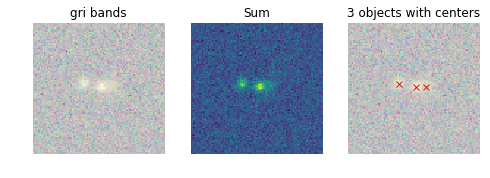

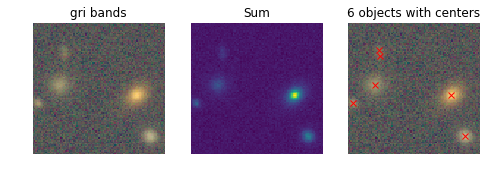

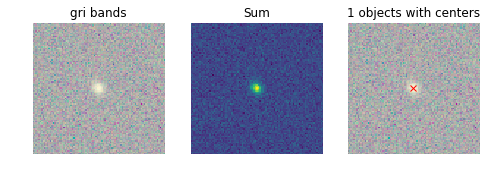

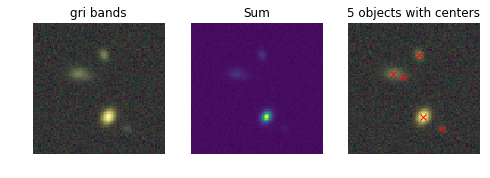

In [13]:
# This cell generates new batch_size number of blends each time it's executed

# Draw blend
blend_results = next(draw_blend_generator)
output = blend_results
blend_images = output['blend_images']
isolated_images = output['isolated_images']
blend_list = output['blend_list']

# Plot blended images
plot_blends(blend_images, blend_list, limits=(15,105))